In [169]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [170]:
n_samples = 10000

In [171]:
def create_blobs(n_modes):
    # n_modes: number of modes for ground truth noise
    
    r = 10  # constellation radius
    noise_std = 0  # 0 for a perfect model, 1 for SNR=1, etc.

    modes = np.random.randint(low=0, high=n_modes, size=n_samples)
    angles = (2 * np.pi / n_modes) * modes
    bias = r * np.vstack([np.cos(angles), np.sin(angles)]).T

    noise = np.random.randn(*x.shape) * noise_std

    y = bias + np.random.randn(n_samples,2) + noise

    return y, modes

In [172]:
def create_spirals(n_modes):
    noise_std = 0.5
    
    n = np.sqrt(np.random.rand(n_samples)) * (4 * np.pi)
    d1x = -np.cos(n) * n + np.random.rand(n_samples) * noise_std
    d1y = np.sin(n) * n + np.random.rand(n_samples) * noise_std

    modes = np.random.randint(low=0, high=n_modes, size=n_samples)
    angles = (2 * np.pi / n_modes) * modes

    y = np.hstack(((d1x * np.cos(angles) + d1y * np.sin(angles))[:, None],
                   (-d1x * np.sin(angles) + d1y * np.cos(angles))[:, None]))
    
    return y, modes

In [173]:
# y, modes = create_blobs(4); n_epochs = 100  # 4 blobs
# y, modes = create_blobs(360); n_epochs = 100  # ring
y, modes = create_spirals(2); n_epochs = 300

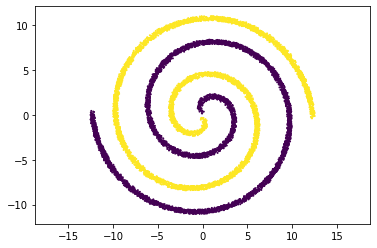

In [174]:
plt.scatter(y[:,0], y[:,1], c=modes, s=1)
plt.axis('equal')
plt.show()

In [175]:
y = torch.from_numpy(y).float()

In [176]:
n_latent_gaussian = 2  # size of the latent gaussian variable
n_latent_one_hot = 2  # length of the latent one-hot code

batch_size = 64  # samples of data distribution at each iteration
latent_batch_size = 256  # number of possible latent codes to try for each sample

In [177]:
def sample_latent_codes(n_latent_samples):
    gaussian_samples = np.random.randn(n_latent_samples, n_latent_gaussian)
    one_hot_samples = np.eye(n_latent_one_hot)[np.random.choice(n_latent_one_hot, n_latent_samples)]
    
    return torch.from_numpy(np.hstack([gaussian_samples, one_hot_samples])).float()

In [178]:
# D_in is input dimension;
# H is hidden dimension;
# D_out is output dimension.

D_in, H, D_out = n_latent_gaussian + n_latent_one_hot, 100, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

In [ ]:
params = list(model.parameters())
    
optimizer = torch.optim.Adam(params, betas=(0.5, 0.999))
loss_fn = torch.nn.MSELoss(reduction='none')

In [229]:
loss_log = []

for epoch in range(1, n_epochs + 1):
    current_epoch_losses = []
    
    for t in range(n_samples // batch_size):
        rand_idx = np.random.randint(low=0, high=n_samples, size=batch_size)
    
        x_train = sample_latent_codes(batch_size * latent_batch_size)
        
        y_train = y[rand_idx].repeat(latent_batch_size, 1)
        y_pred = model(x_train)

        loss_all_modes = loss_fn(y_pred, y_train)

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()
        
        selective_loss = loss_all_modes.mean(dim=1).reshape(latent_batch_size, batch_size).min(dim=0)[0].sum()
        selective_loss.backward()
        
        current_epoch_losses.append(selective_loss)
        
        optimizer.step()
    
    loss_log.append(torch.tensor(current_epoch_losses).mean().detach().numpy())
    
    if True:  # if epoch % 10 == 0:
        print('Epoch: {} / Loss: {:.2f}'.format(epoch, loss_log[-1]))

Epoch: 1 / Loss: 8.60
Epoch: 2 / Loss: 8.38
Epoch: 3 / Loss: 8.10
Epoch: 4 / Loss: 8.26
Epoch: 5 / Loss: 8.19
Epoch: 6 / Loss: 8.17
Epoch: 7 / Loss: 8.64
Epoch: 8 / Loss: 8.35
Epoch: 9 / Loss: 8.18
Epoch: 10 / Loss: 8.46
Epoch: 11 / Loss: 8.21
Epoch: 12 / Loss: 8.12
Epoch: 13 / Loss: 8.34
Epoch: 14 / Loss: 8.50
Epoch: 15 / Loss: 8.24
Epoch: 16 / Loss: 8.27
Epoch: 17 / Loss: 8.43
Epoch: 18 / Loss: 8.45
Epoch: 19 / Loss: 7.75
Epoch: 20 / Loss: 8.35
Epoch: 21 / Loss: 8.07
Epoch: 22 / Loss: 8.12
Epoch: 23 / Loss: 8.17
Epoch: 24 / Loss: 8.15
Epoch: 25 / Loss: 8.08
Epoch: 26 / Loss: 8.18
Epoch: 27 / Loss: 8.22
Epoch: 28 / Loss: 7.95
Epoch: 29 / Loss: 8.12
Epoch: 30 / Loss: 8.35
Epoch: 31 / Loss: 8.23
Epoch: 32 / Loss: 8.24
Epoch: 33 / Loss: 7.96
Epoch: 34 / Loss: 8.35
Epoch: 35 / Loss: 8.47
Epoch: 36 / Loss: 8.29
Epoch: 37 / Loss: 8.41
Epoch: 38 / Loss: 8.23
Epoch: 39 / Loss: 7.99
Epoch: 40 / Loss: 8.33
Epoch: 41 / Loss: 8.43
Epoch: 42 / Loss: 8.29
Epoch: 43 / Loss: 8.03
Epoch: 44 / Loss: 8.

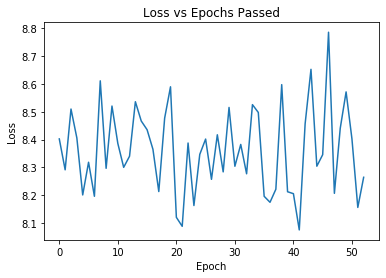

In [227]:
plt.figure()
plt.title('Loss vs Epochs Passed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_log)), loss_log)
plt.show()

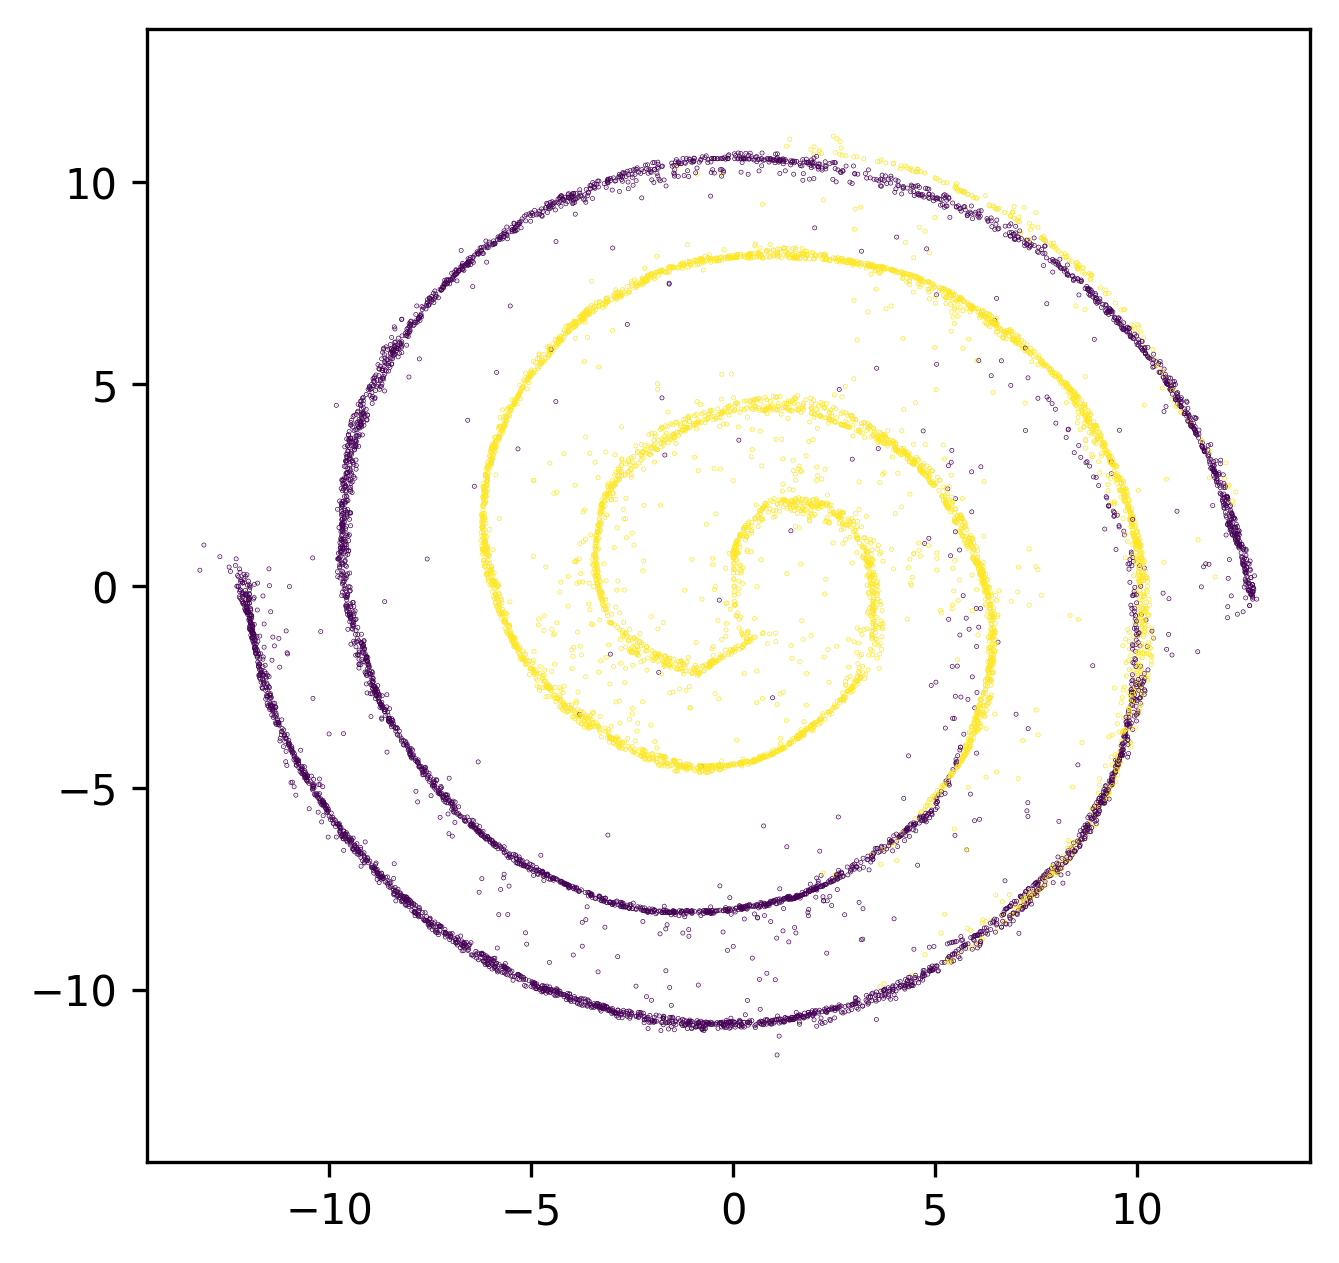

In [228]:
x_test = sample_latent_codes(n_samples)
y_pred = model(x_test).detach().numpy()

plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(y_pred[:, 0], y_pred[: ,1], marker='.', s=0.1, c=x_test[:, 3].numpy())
plt.axis('equal')
plt.show()